In [1]:
import sys
sys.path.append('../')

from low_rank_rnns.modules import *
from low_rank_rnns import CFD, stats, plotting as plot, helpers, rankone, ranktwo, clustering



In [2]:
size = 100
noise_std = 5e-2
alpha = .2
lr = 1e-2



In [3]:
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = CFD.generate_checker_data(5000)
net = FullRankRNN(3, size, 1, noise_std, alpha, train_wi=True, train_wo = True, train_h0=True)


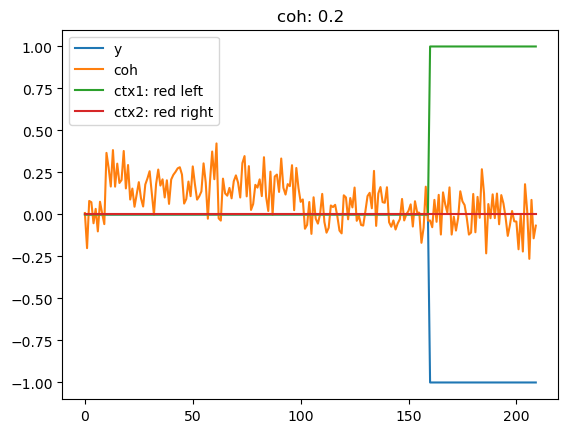

In [4]:
n = 5

plt.plot(y_val[n,:,:], label = 'y')
plt.plot(x_val[n,:,0], label = 'coh')
plt.plot(x_val[n,:,1], label = 'ctx1: red left')
plt.plot(x_val[n,:,2], label = 'ctx2: red right')
plt.title('coh: ' + str(cohAll_val[n]))
plt.legend()

In [5]:

# net_fr = FullRankRNN(1, hidden_size, 1, noise_std, alpha)

net.non_linearity = torch.tanh

train(net, x_train, y_train, mask_train, n_epochs=50, lr=lr / sqrt(size), batch_size=50, keep_best=True, cuda=True, early_stop=0.05)

x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net)

# will only choose 1 of the 2  
# out = net.forward(x_val)
loss, acc, out, decisions, target_decisions, traj = CFD.test_checker(net, x_val, y_val, mask_val)

print(acc)
# torch.save(net.state_dict(), f'../models/CFD1{size}.pt')

Training...
initial loss: 0.239
epoch 0:  loss=0.127  (took 10.18 s) *
epoch 1:  loss=0.025  (took 9.80 s) *
1.0


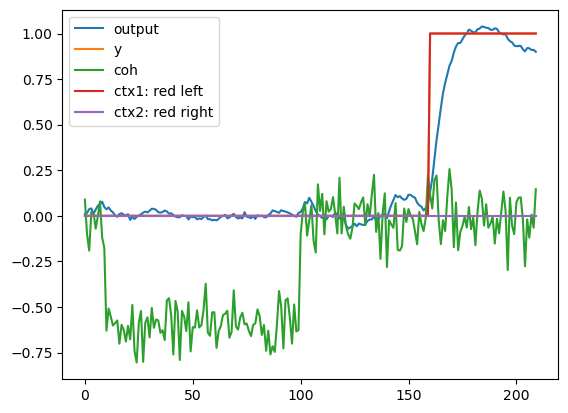

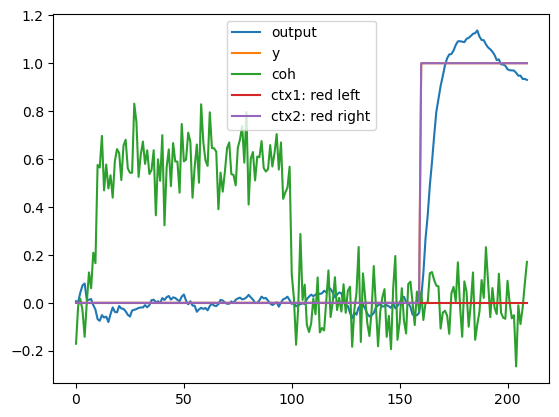

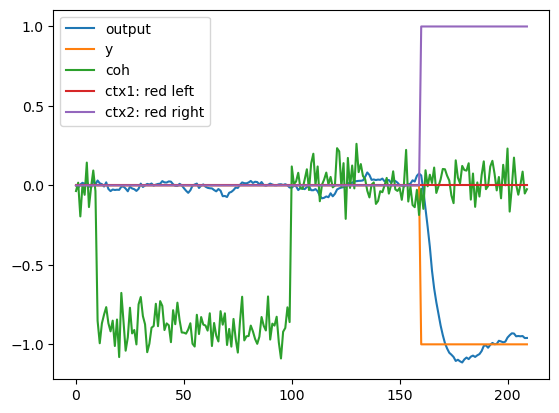

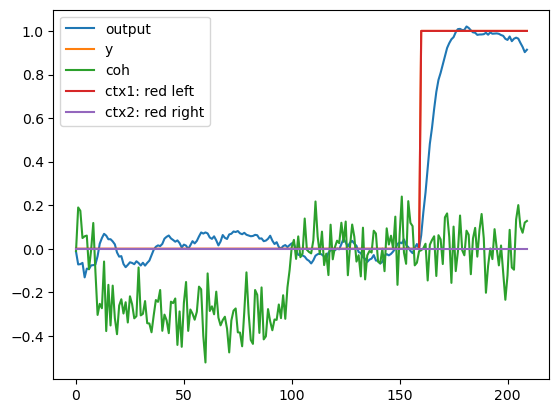

In [7]:
for n in range(986, 990):
    plt.figure()
    aa = out.detach().numpy()
    plt.plot(aa[n,:,:], label = 'output')
    plt.plot(y_val[n,:,:], label = 'y')

    plt.plot(x_val[n,:,0], label = 'coh')
    plt.plot(x_val[n,:,1], label = 'ctx1: red left')
    plt.plot(x_val[n,:,2], label = 'ctx2: red right')

    plt.legend()
    plt.show()

# plot PSTH

In [7]:
traj1 = traj.detach().numpy()
traj1 = np.tanh(traj1)
decisions1 = decisions.detach().numpy()

cfdRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
cfdRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
cfdGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
cfdGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

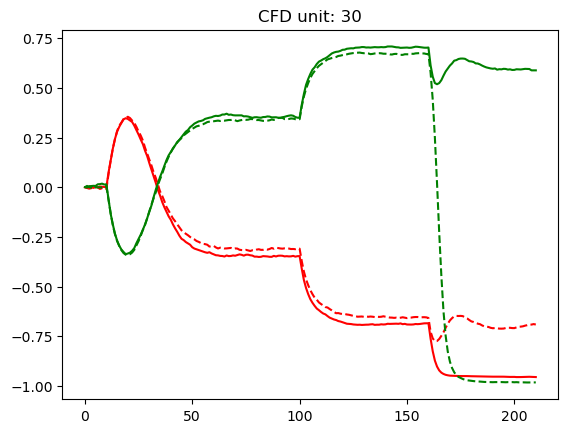

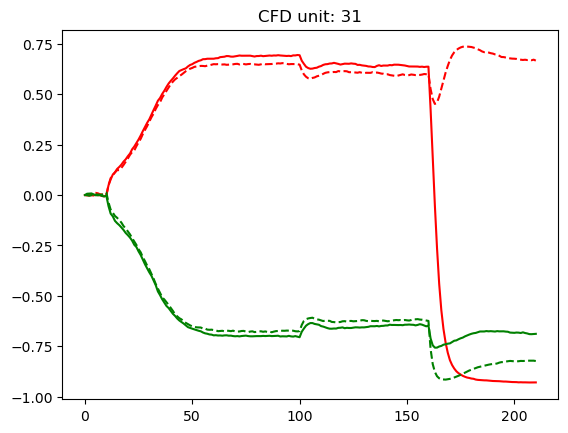

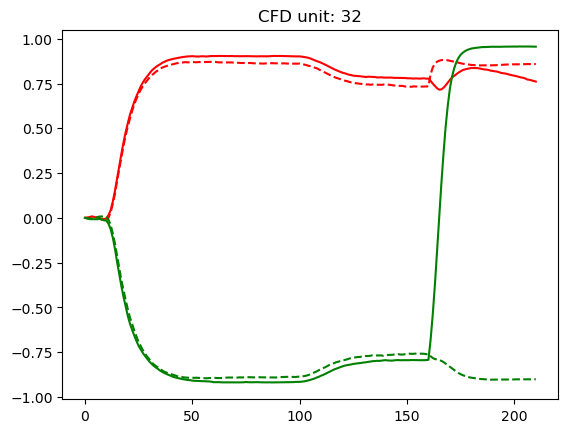

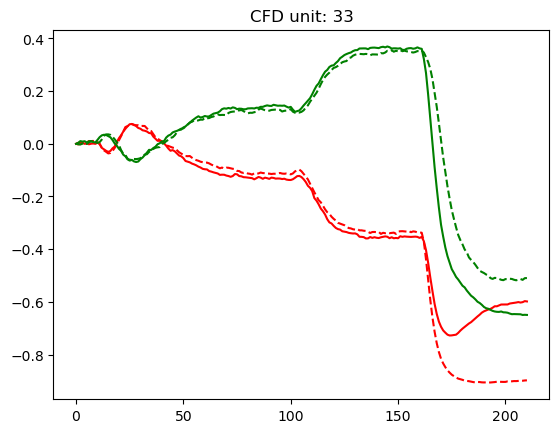

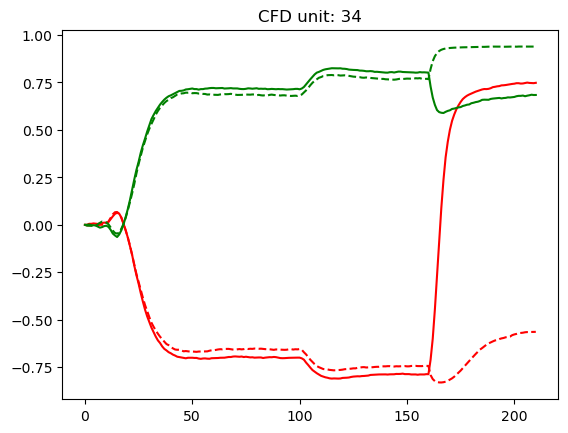

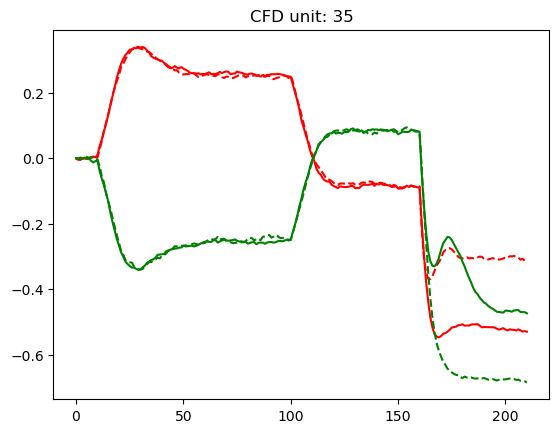

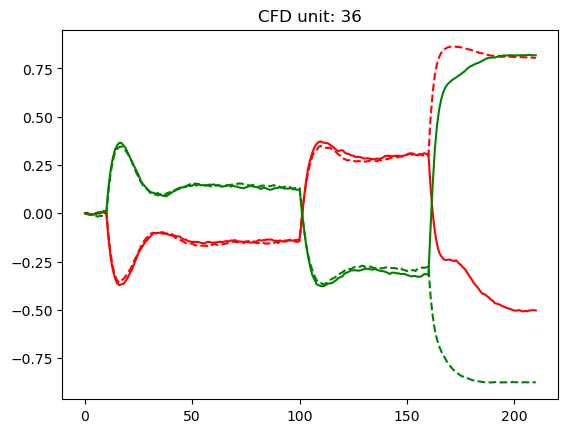

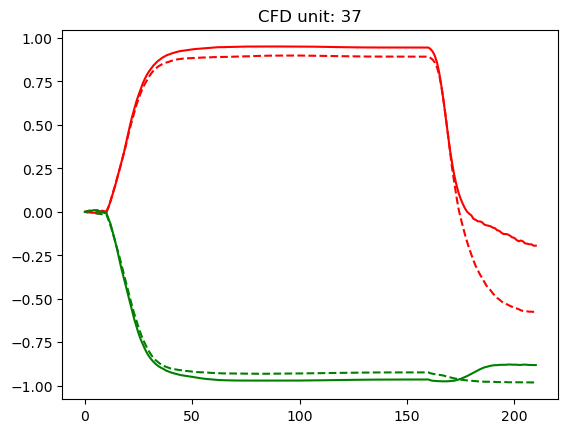

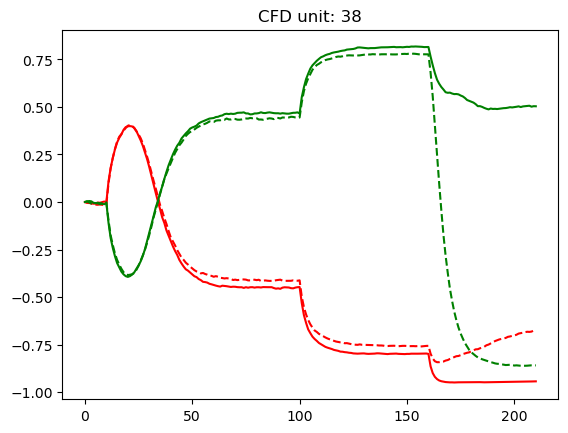

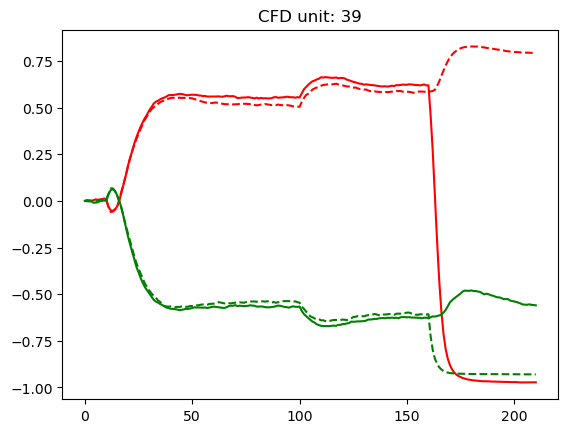

In [8]:
for n in range(30,40):
    plt.figure()
    plt.plot(np.mean(cfdRL,axis = 0)[:,n], 'r-')
    plt.plot(np.mean(cfdRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(cfdGL,axis = 0)[:,n], 'g-')
    plt.plot(np.mean(cfdGR,axis = 0)[:,n], 'g--')
    plt.title("CFD unit: " + str(n))

# plot psychometric curves

In [9]:
out1 = out.detach().numpy()
mask_val1 = mask_val.detach().numpy()
temp = out1*mask_val1

In [31]:
targetsOn = 160
response = 50
rt = np.zeros(y_val.shape[0])

for i in range(temp.shape[0]):
    oneTrial = temp[i,:,:]
    if len(np.where(np.absolute(oneTrial) > 0.9)[0]) > 0: 
        rt[i] = np.where(np.absolute(oneTrial) > 0.9)[0][0] - targetsOn
    else:
        rt[i] =  response
    
    

In [45]:
coherences = [-0.9, -0.6, -0.4, -0.3, -0.2,-0.1, 0.1, 0.2, 0.3, 0.4, 0.6, 0.9]
decisions1 = decisions.detach().numpy()
target_decisions1 = target_decisions.detach().numpy()

aveAcc = np.zeros(len(coherences))
aveRT = np.zeros((len(coherences)))

for i in range(len(coherences)):
    
    select = (cohAll_val == coherences[i]).astype(int)
    aveAcc[i] = np.sum((decisions1[select == 1] == target_decisions1[select == 1]).astype(int)) / np.sum(select)

    aveRT[i] = np.mean(rt[select])


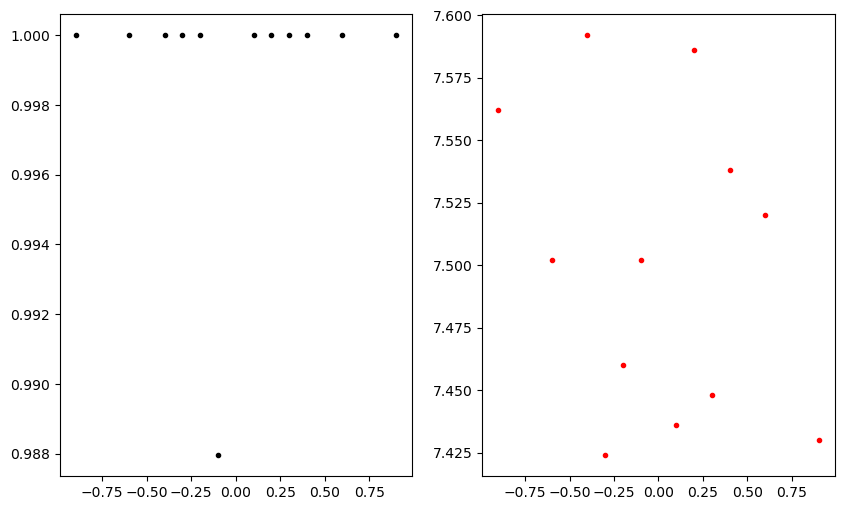

In [47]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.plot(coherences, aveAcc, 'k.')
plt.subplot(122)
plt.plot(coherences, aveRT, 'r.')

# train low-rank RNN

In [23]:
# load a full-rank RNN

# net = FullRankRNN(3, size, 1, noise_std, alpha)
# net.load_state_dict(torch.load(f'../models/CFD1{size}.pt', map_location='cpu'))

# x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = CFD.generate_checker_data(5000)

# loss, acc, out, decisions, target_decisions, traj = CFD.test_checker(net, x_val, y_val, mask_val)
# print(f'loss={loss:.3f}, acc={acc:.3f}')

loss=0.028, acc=1.000


In [8]:
# define some parameters
# hidden_size: # units in low-rank RNN (should match that in full-rank RNN)
hidden_size = 100
rank = 5

In [9]:
# you have to save model for full-rank RNN, then use that to train low-rank RNN 

# reduce the rank of connectivity matrix 
wi_init = net.wi_full.detach()
wo_init = net.wo_full.detach() * hidden_size
print(wo_init.std())
wrec = net.wrec.detach().cpu().numpy()
u, s, v = np.linalg.svd(wrec)
m_init = torch.from_numpy(s[:rank] * u[:, :rank]).to(device=net.wrec.device) * sqrt(hidden_size)
n_init = torch.from_numpy(v[:rank, :].transpose()).to(device=net.wrec.device) * sqrt(hidden_size)
print(m_init.std())
print(n_init.std())

print(m_init.shape)
print(n_init.shape)

tensor(4.2477)
tensor(1.9520)
tensor(1.0009)
torch.Size([100, 5])
torch.Size([100, 5])


In [10]:
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = CFD.generate_checker_data(5000)


In [11]:
## We see that the rank-1 network failed. Must be rank 2
net_lo = LowRankRNN(3, hidden_size, 1, noise_std, alpha, rank=rank, wi_init=wi_init, wo_init=wo_init, m_init=m_init, n_init=n_init)

train(net_lo, x_train, y_train, mask_train, n_epochs=10, lr=lr, batch_size=50, keep_best=True, cuda=True, clip_gradient=0.01, early_stop=0.05)
x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net_lo)
# out = net_lo.forward(x_val)
# print("Final loss: {:.3f}".format(loss_mse(out, y_val, mask_val)))

loss, acc, out, decisions, target_decisions, traj = CFD.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

# save the low-rank model
# torch.save(net_lo.state_dict(), "../models/CFD_rank3_2_{}.pt".format(hidden_size))


Training...
initial loss: 0.343
epoch 0:  loss=0.248  (took 11.38 s) *
epoch 1:  loss=0.238  (took 11.03 s) *
epoch 2:  loss=0.238  (took 11.06 s) *
epoch 3:  loss=0.238  (took 11.49 s) *
epoch 4:  loss=0.238  (took 11.00 s)
epoch 5:  loss=0.238  (took 11.05 s)
epoch 6:  loss=0.238  (took 11.29 s)
epoch 7:  loss=0.238  (took 11.18 s)
epoch 8:  loss=0.238  (took 11.06 s)
epoch 9:  loss=0.238  (took 11.25 s)
loss=0.239, acc=0.487


In [41]:
# load a low-rank RNN

# x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = CFD.generate_checker_data(5000)

# net_lo = LowRankRNN(3, size, 1, noise_std, alpha, rank=3)
# net_lo.load_state_dict(torch.load(f'../models/CFD_rank3_{size}.pt', map_location='cpu'))

# loss, acc, out, decisions, target_decisions, traj = CFD.test_checker(net_lo, x_val, y_val, mask_val)
# print(f'loss={loss:.3f}, acc={acc:.3f}')


loss=0.549, acc=0.885


# plot results

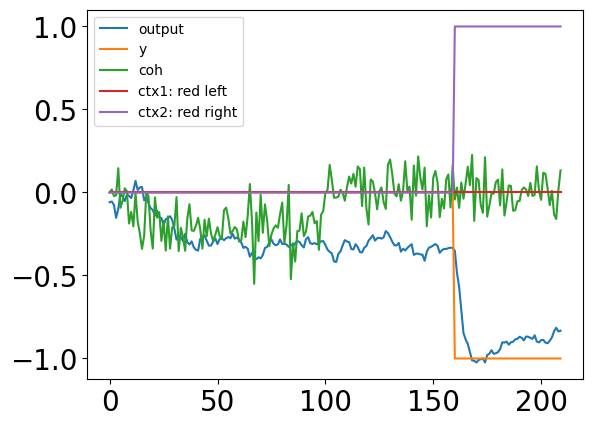

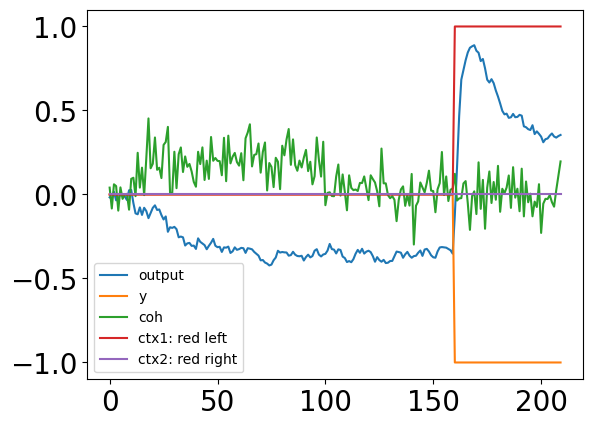

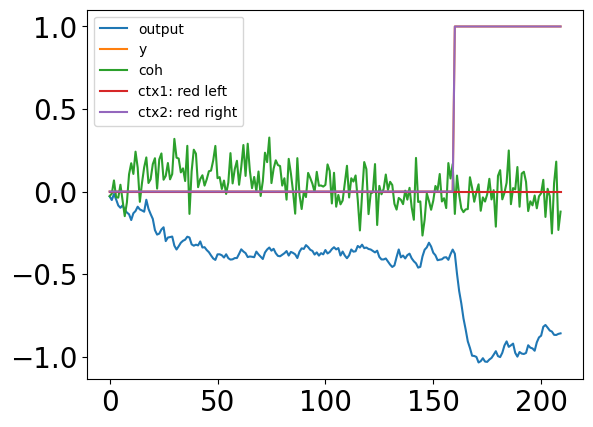

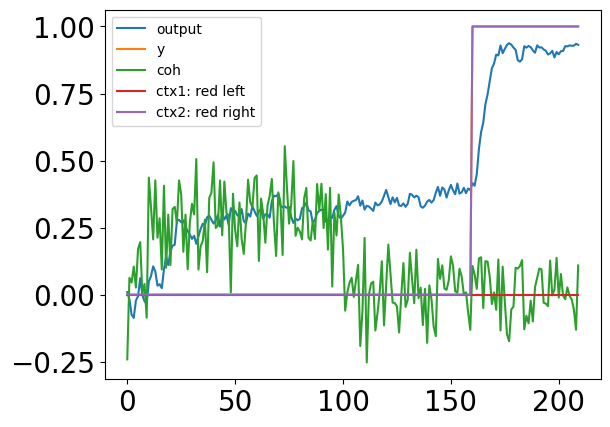

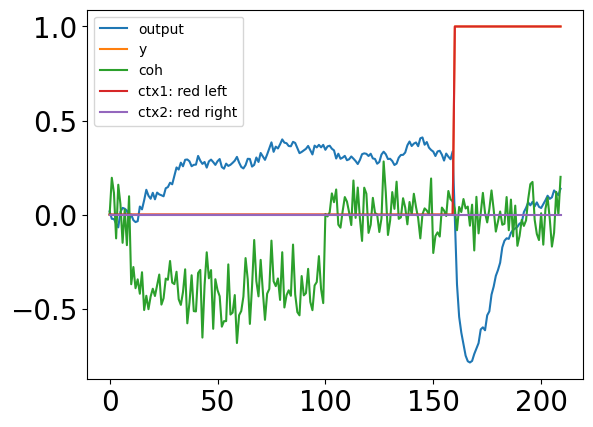

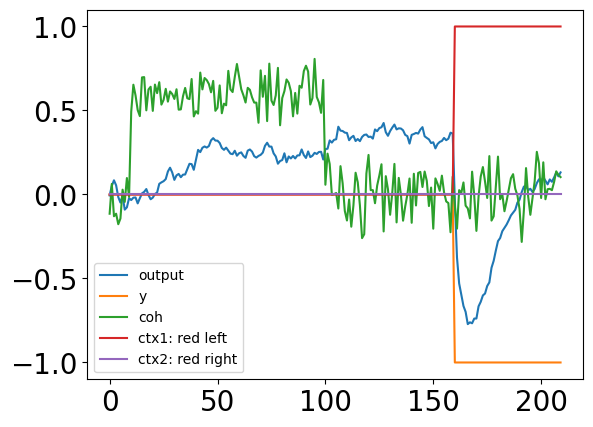

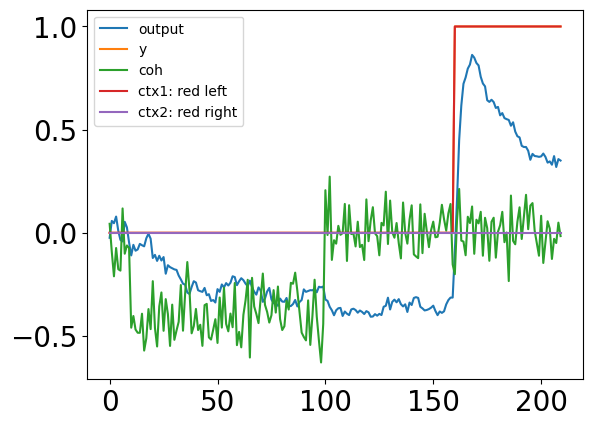

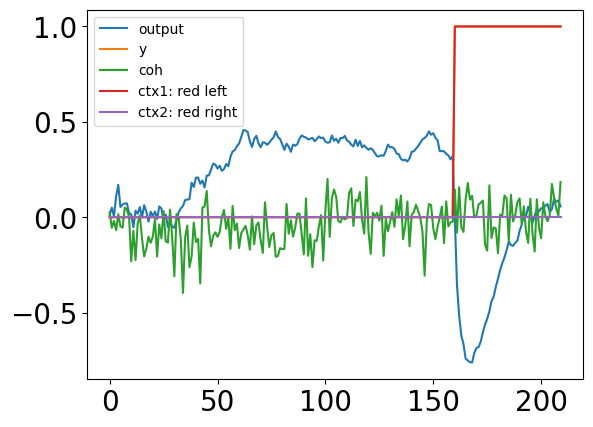

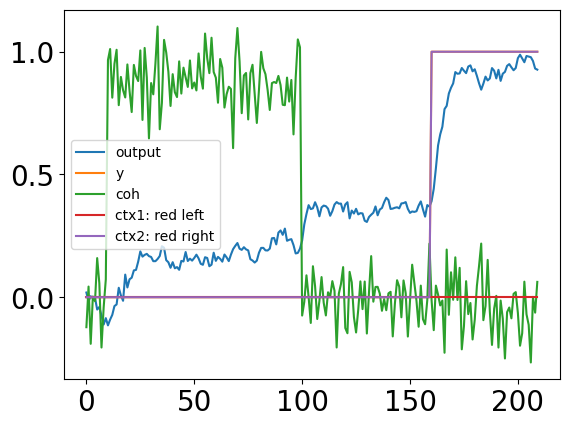

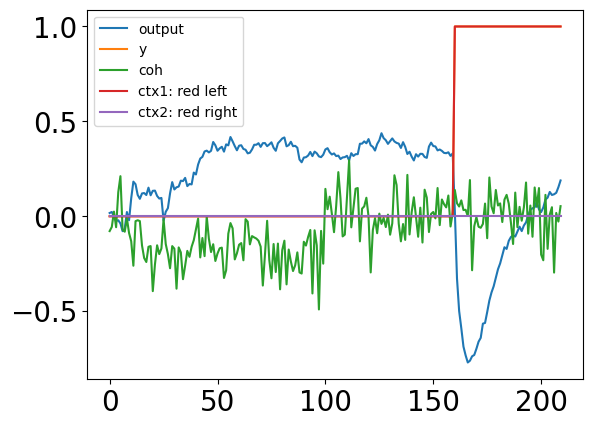

In [42]:
for n in range(10, 20):
    plt.figure()
    aa = out.detach().numpy()
    plt.plot(aa[n,:,:], label = 'output')
    plt.plot(y_val[n,:,:], label = 'y')

    plt.plot(x_val[n,:,0], label = 'coh')
    plt.plot(x_val[n,:,1], label = 'ctx1: red left')
    plt.plot(x_val[n,:,2], label = 'ctx2: red right')

    plt.legend()
    plt.show()

# plot psth

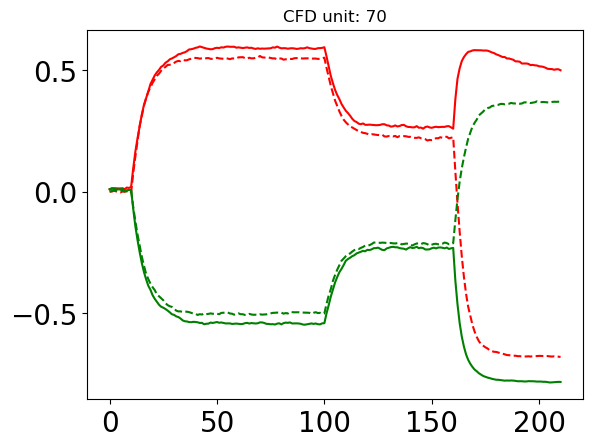

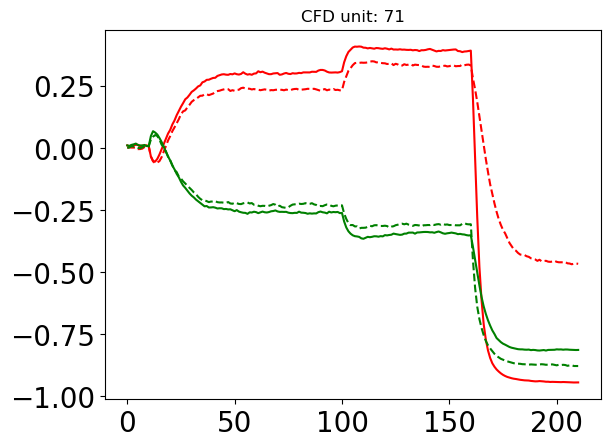

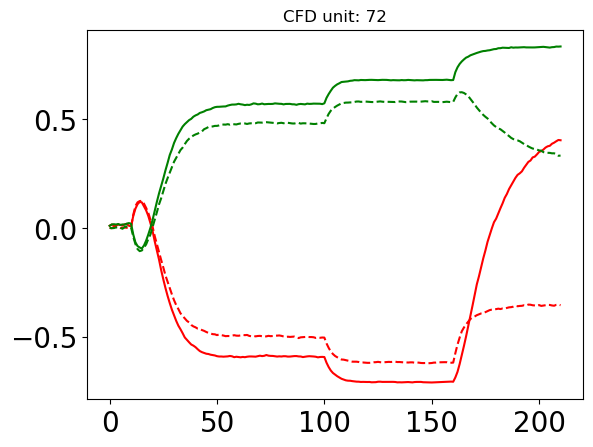

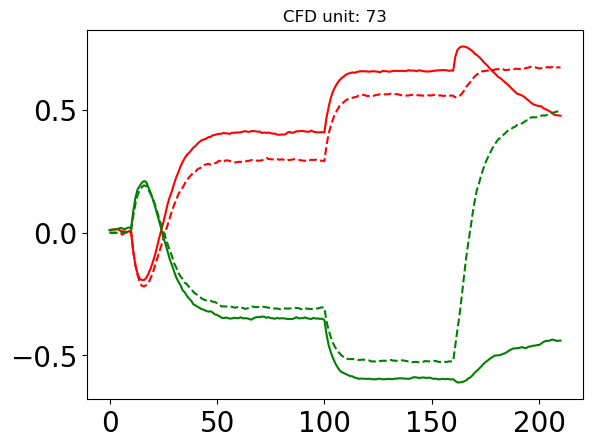

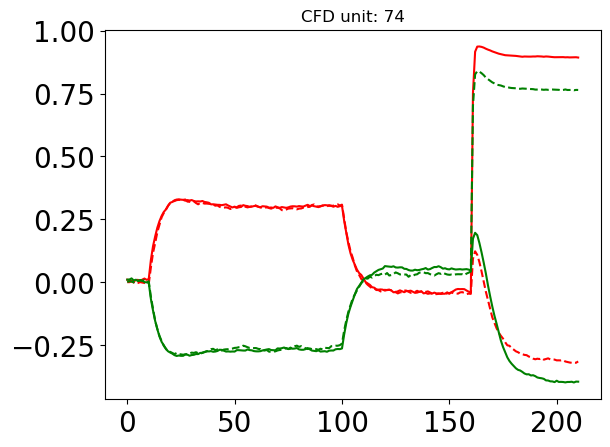

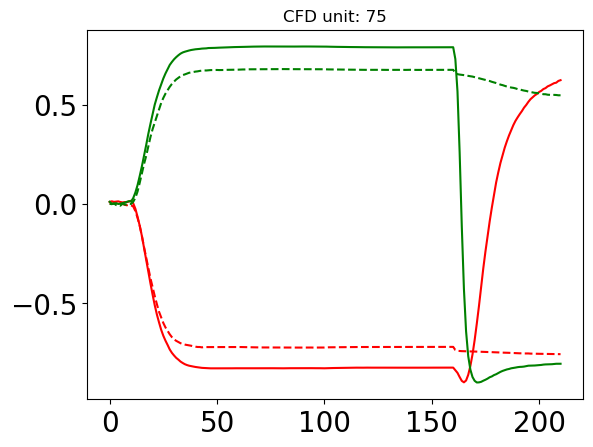

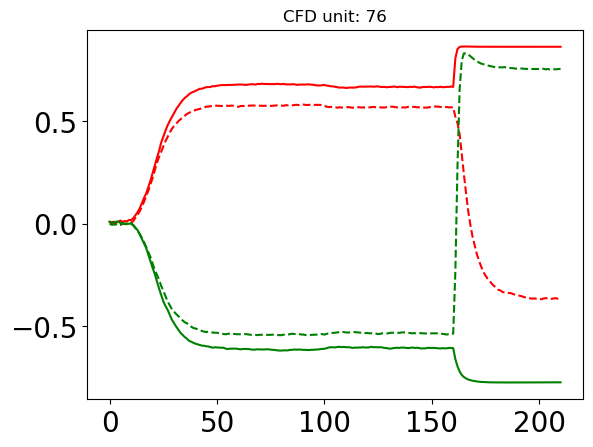

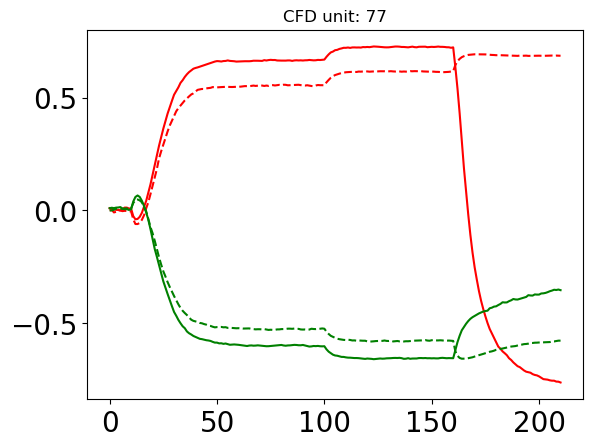

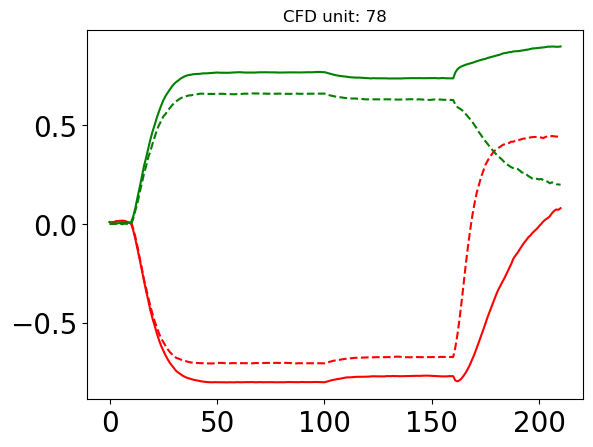

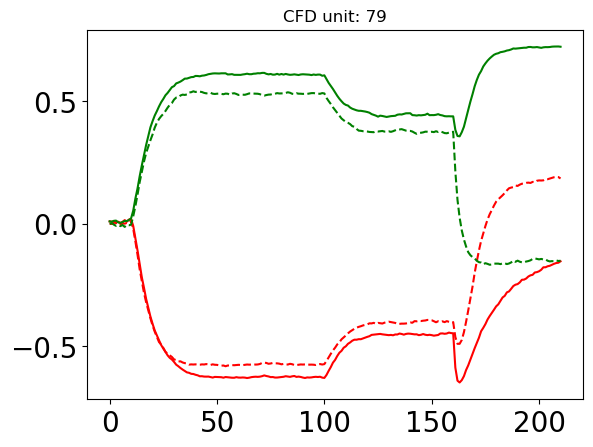

In [43]:
traj1 = traj.detach().numpy()

traj1 = np.tanh(traj1)
decisions1 = decisions.detach().numpy()

cfdRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
cfdRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
cfdGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
cfdGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

for n in range(70,80):
    plt.figure()
    plt.plot(np.mean(cfdRL,axis = 0)[:,n]+0.01, 'r-')
    plt.plot(np.mean(cfdRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(cfdGL,axis = 0)[:,n]+0.01, 'g-')
    plt.plot(np.mean(cfdGR,axis = 0)[:,n], 'g--')
    plt.title("CFD unit: " + str(n))

0.252777671153645
0.4118846681771725


(-1.0, 1.0)

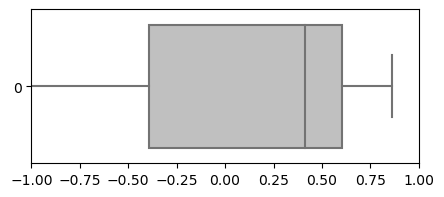

In [9]:
# ## remember to change the net.nonlinearity

# fig, ax = plt.subplots(figsize=(5, 2))
# outp, traj = net.forward(x_val, return_dynamics=True)
# outp2, traj2 = net_lo.forward(x_val, return_dynamics=True)

# traj = traj.detach().numpy()
# traj2 = traj2.detach().numpy()
# r2_global = stats.r2_score(np.tanh(traj).ravel(), np.tanh(traj2).ravel())

# print(r2_global)
# r2s = stats.r2_idneurons(traj, traj2, return_all=True)
# print(np.median(r2s))
# sns.boxplot(r2s, orient='horizontal', color='silver', ax=ax)
# plt.xlim(-1, 1)

In [44]:
net_lo.svd_reparametrization()
wi1 = net_lo.wi[0].detach().numpy()
wi2 = net_lo.wi[1].detach().numpy()
wi3 = net_lo.wi[2].detach().numpy()
# n: low-rank Wrec connectivity vector n
n1 = net_lo.n[:, 0].detach().numpy()
n2 = net_lo.n[:, 1].detach().numpy()
n3 = net_lo.n[:, 2].detach().numpy()

# m: low-rank Wrec connectivity vector m
m1 = net_lo.m[:, 0].detach().numpy()
m2 = net_lo.m[:, 1].detach().numpy()
m3 = net_lo.m[:, 2].detach().numpy()

wo = net_lo.wo.detach().squeeze().numpy()

In [45]:
# 1st way to generate low-traj
loss, acc, out, decisions, target_decisions, traj = CFD.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

traj1 = traj.detach().numpy()

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

trajLow = np.zeros((4, tfRL.shape[1], tfRL.shape[2]))
trajLow[0,:,:] = np.mean(tfRL,axis = 0)
trajLow[1,:,:] =np.mean(tfRR,axis = 0)
trajLow[2,:,:] =np.mean(tfGL,axis = 0)
trajLow[3,:,:] =np.mean(tfGR,axis = 0)

loss=0.555, acc=0.882


In [14]:
# # generate 4 trials, each represent a condition
# x = CFD.generate_ordered_inputs()

# _, trajFull = net.forward(x, return_dynamics=True)
# _, trajLow = net_lo.forward(x, return_dynamics=True)

# trajFull = trajFull.detach().numpy()
# trajLow = trajLow.detach().numpy()

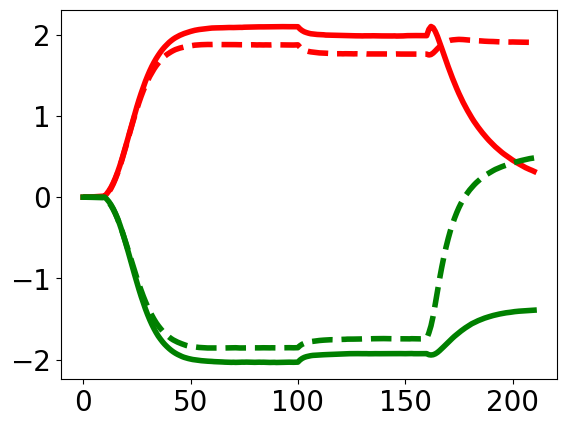

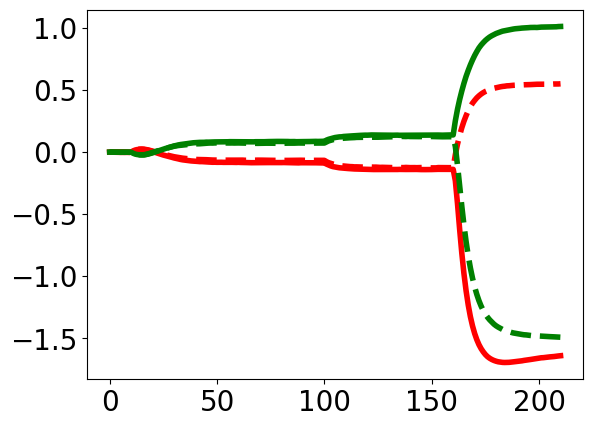

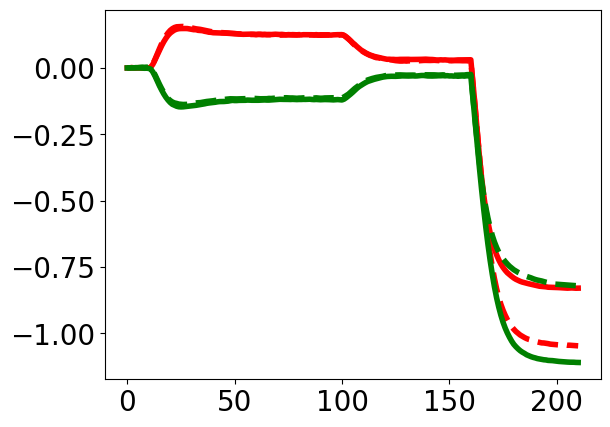

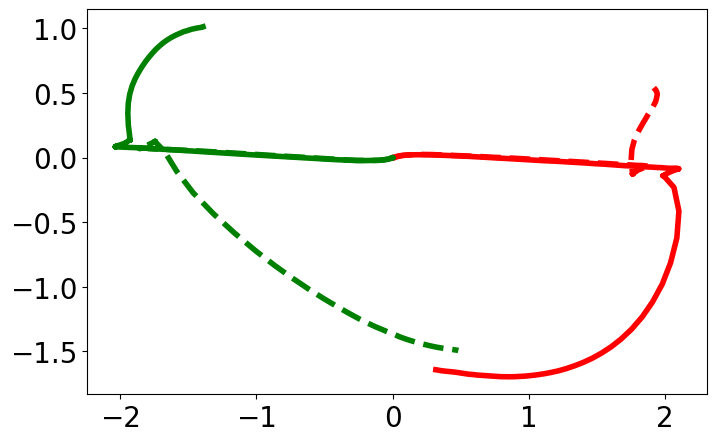

In [47]:
# project full rank rnn traj on m1 vector
# kap1 = trajFull @ m1 / size
# kap2 = trajFull @ m2 / size

# project low rank rnn traj on m1 vector
kap1 = trajLow @ m1 / size
kap2 = trajLow @ m2 / size
kap3 = trajLow @ m3 / size

colors = ['red', 'red', 'green', 'green']
lineStyle = ['-', '--', '-', '--']
plt.figure()
for i in range(4):
    plt.plot(kap1[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(kap2[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(kap3[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()



plt.subplots(figsize=(8,5))
colors = ['red', 'red', 'green', 'green']
lineStyle = ['-', '--', '-', '--']
for i in range(4):
#     plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
     plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls=lineStyle[i])

In [34]:
# full rank pca

colors = ['red', 'red', 'green', 'green']
lineStyle = ['-', '--', '-', '--']
COn = 10
COff = 100
TOn = 160

pca = plot.pca_cumvar(trajFull, n_components=10)
plt.ylim(0, 1.02)
plt.axhline(1, ls='--', c='gray')
plt.show()



ax1 = pca.components_[0]
ax2 = pca.components_[1]
ax3 = pca.components_[2]
ax4 = pca.components_[3]

k1 = trajFull @ ax1
k2 = trajFull @ ax2
k3 = trajFull @ ax3
k4 = trajFull @ ax4

plt.figure()
for i in range(4):
    plt.plot(k2[i], k1[i], c=colors[i], lw=4, ls = lineStyle[i])
plt.show()
    
# 3D pca plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(4):
    plt.plot(k1[i], k2[i], k3[i], c=colors[i], lw=4, ls = lineStyle[i])
    ax.scatter(k1[i, COn], k2[i, TOn], k3[i, COn], c='magenta',
            marker='.', s=400)
    ax.scatter(k1[i, COff], k2[i, COff], k3[i, COff], c= 'yellow',
            marker='.', s=400)
    ax.scatter(k1[i, TOn], k2[i, TOn], k3[i, TOn], c= 'black',
            marker='.', s=400)
# ax.view_init(elev=38, azim=90)
plt.show()

NameError: name 'trajFull' is not defined

(844, 100)


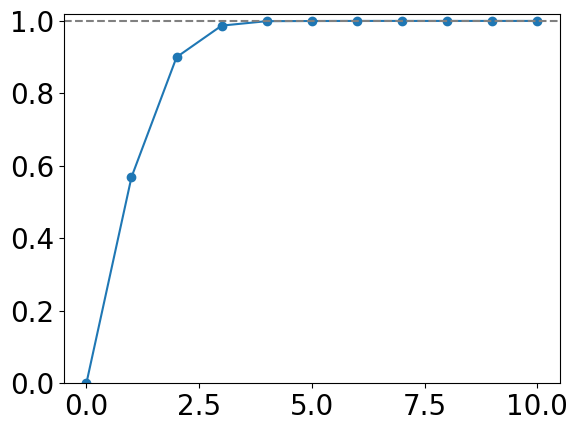

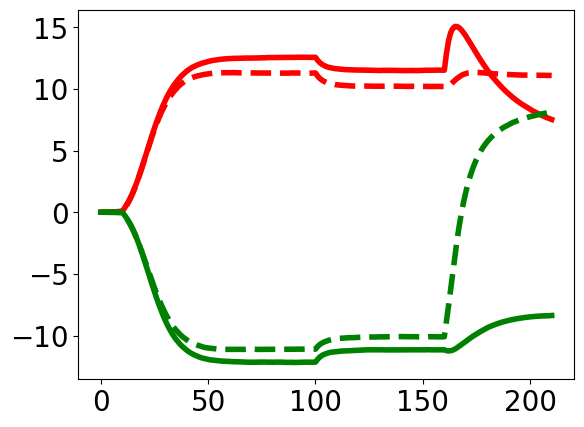

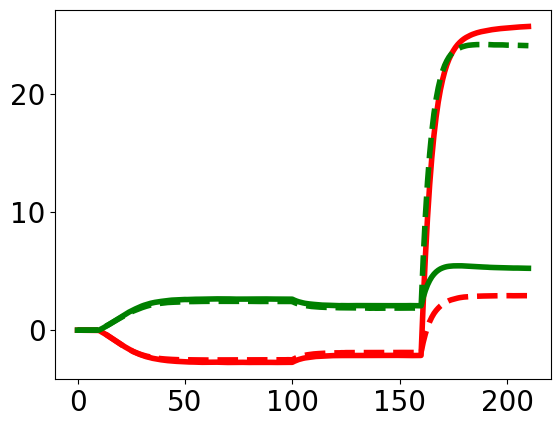

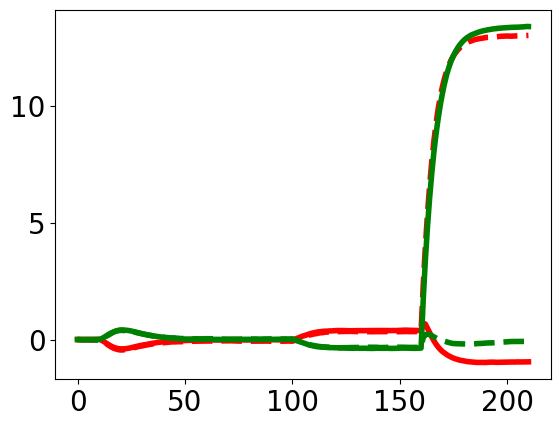

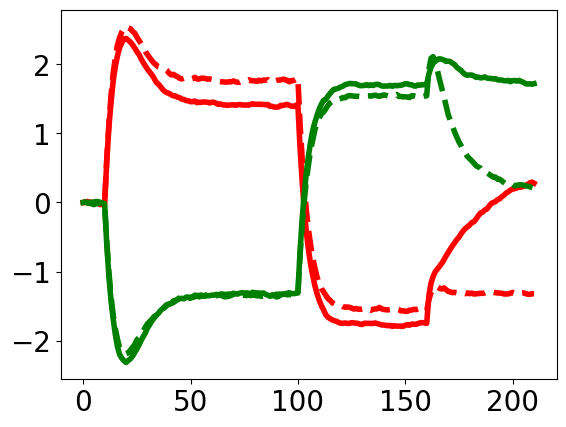

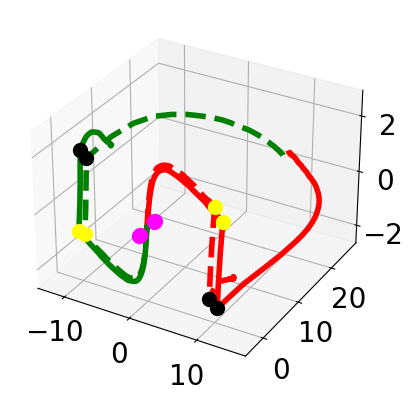

In [48]:
# low rank RNN pca
pca = plot.pca_cumvar(trajLow, n_components=10)
plt.ylim(0, 1.02)
plt.axhline(1, ls='--', c='gray')
plt.show()

colors = ['red', 'red', 'green', 'green']
lineStyle = ['-', '--', '-', '--']
COn = 10
COff = 100
TOn = 160

ax1 = pca.components_[0]
ax2 = pca.components_[1]
ax3 = pca.components_[2]
ax4 = pca.components_[3]

k1 = trajLow @ ax1
k2 = trajLow @ ax2
k3 = trajLow @ ax3
k4 = trajLow @ ax4

plt.figure()
for i in range(4):
    plt.plot(k1[i], c=colors[i], lw=4, ls = lineStyle[i])
plt.show()


plt.figure()
for i in range(4):
#      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
    plt.plot(k2[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
#      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
    plt.plot(k3[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(k4[i], c=colors[i], lw=4, ls = lineStyle[i])
plt.show()



# 3D pca plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(4):
    plt.plot(k1[i], k2[i], k4[i], c=colors[i], lw=4, ls = lineStyle[i])
    ax.scatter(k1[i, COn], k2[i, TOn], k4[i, COn], c='magenta',
            marker='.', s=400)
    ax.scatter(k1[i, COff], k2[i, COff], k4[i, COff], c= 'yellow',
            marker='.', s=400)
    ax.scatter(k1[i, TOn], k2[i, TOn], k4[i, TOn], c= 'black',
            marker='.', s=400)

# ax.view_init(elev=38, azim=90)
plt.show()

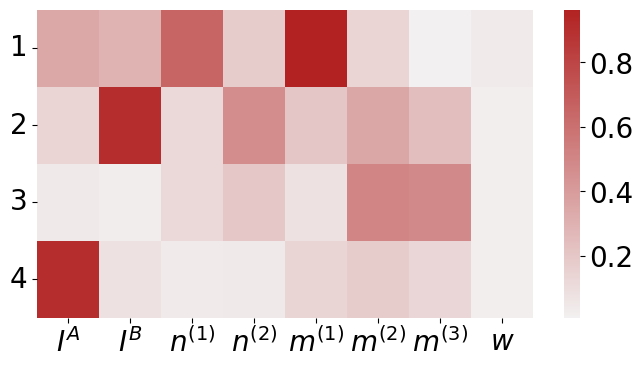

In [49]:
vecs_pca = [ax1, ax2, ax3, ax4]
vecs_fit = [wi1, wi2, n1, n2, m1, m2, m3, wo]

helpers.overlap_matrix2(vecs_pca, vecs_fit, norm='l2', figsize=(8,4), abs=True, cmap='abs')
# plt.xlabel('Fitted connectivity')
# plt.ylabel('TDR axes')
plt.xticks(np.arange(0.5, 8, 1), ['$I^A$', '$I^B$', '$n^{(1)}$', '$n^{(2)}$', '$m^{(1)}$', '$m^{(2)}$', '$m^{(3)}$', '$w$'])
plt.yticks(np.arange(0.5, 4, 1), ['1', '2', '3', '4'], rotation='horizontal')
plt.show()

# fields

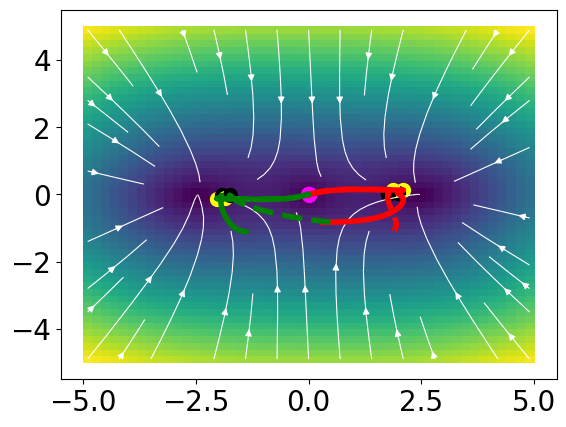

In [51]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
ranktwo.plot_field(net_lo, m1, m3, -5, 5, -5, 5)
for i in range(4):
    plt.plot(kap1[i], kap3[i], c=colors[i], lw=4, ls=lineStyle[i])
    plt.scatter(kap1[i, COn], kap3[i, COn], c='magenta',
            marker='.', s=400)
    plt.scatter(kap1[i, COff], kap3[i, COff], c= 'yellow',
            marker='.', s=400)
    plt.scatter(kap1[i, TOn], kap3[i, TOn], c= 'black',
            marker='.', s=400)        